**Importing the required libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

#XGBoost
import xgboost as xgb

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

import re

In [2]:
url = 'data/auto-mpg.data'

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'ModelYear', 'Origin', 'CarName']

df = pd.read_fwf(url, names = column_names, na_values = "?")
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin,CarName
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,"""chevrolet chevelle malibu"""
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,"""buick skylark 320"""
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,"""plymouth satellite"""
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,"""amc rebel sst"""
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,"""ford torino"""


In [3]:
df.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [4]:
df['CarName'].nunique()

305

In [5]:
df['BrandName'] = df['CarName'].str.split(' ').str[0]

In [6]:
df['BrandName'] = df['BrandName'].map(lambda x: re.sub(r'\W+', '', x))

In [7]:
# I will delete Car and Brand names just for now. In advanced version of this notebook, I aim to use them.

df = df.drop(['CarName', 'BrandName'],1)

In [8]:
df.rename(columns = {'MPG':'target'}, inplace=True)
df.head()

,target,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


**Handling the null values**

In [9]:
df.isna().sum()

target          0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
ModelYear       0
Origin          0
dtype: int64

In [10]:
list(df['Horsepower'][df['Horsepower'].isnull()].index)

[32, 126, 330, 336, 354, 374]

<AxesSubplot:xlabel='Horsepower', ylabel='Density'>

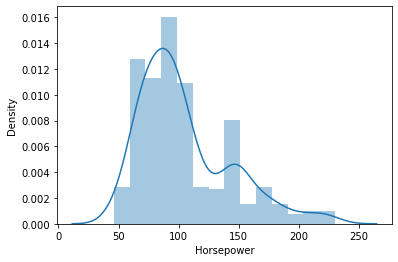

In [11]:
# We can handle null values by replacing them with Horsepower's mean value.

df['Horsepower'] = df['Horsepower'].fillna(df['Horsepower'].mean())
sns.distplot(df['Horsepower'])

In [12]:
df.isna().sum()

target          0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
ModelYear       0
Origin          0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   target        398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    398 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   ModelYear     398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


**Exploratory Data Analysis**

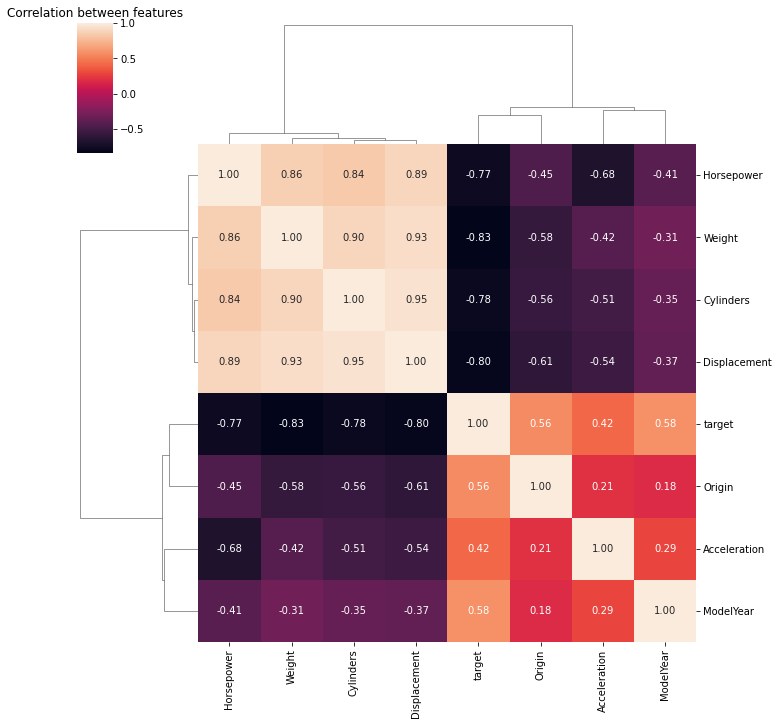

In [14]:
corr_matrix = df.corr()
sns.clustermap(corr_matrix, annot = True, fmt = ".2f")
plt.title('Correlation between features')
plt.show()

In [15]:
threshold = 0.75
filtre = np.abs(corr_matrix["target"]) > threshold
corr_features = corr_matrix.columns[filtre].tolist()

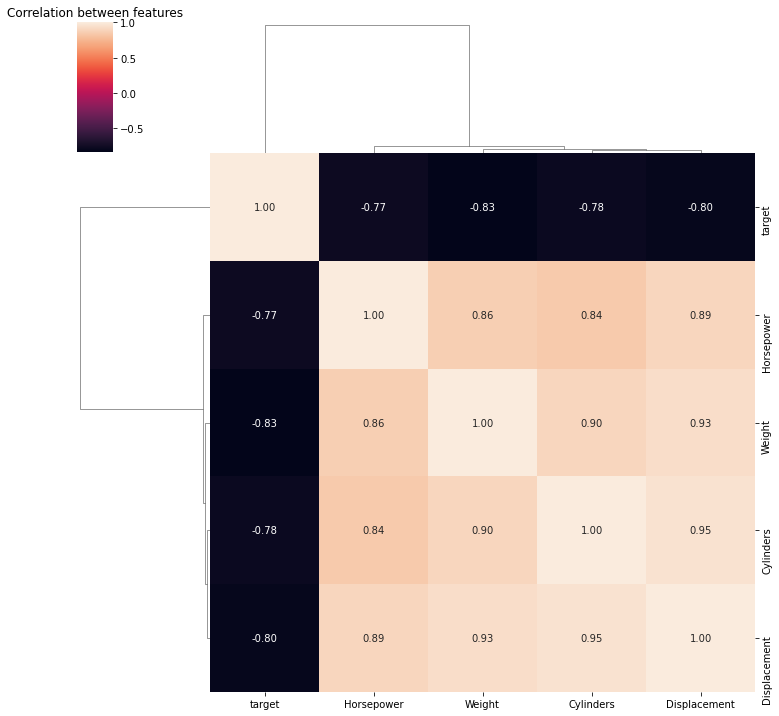

In [16]:
sns.clustermap(df[corr_features].corr(), annot = True, fmt = ".2f")
plt.title('Correlation between features')
plt.show()

There is multicollinearity.

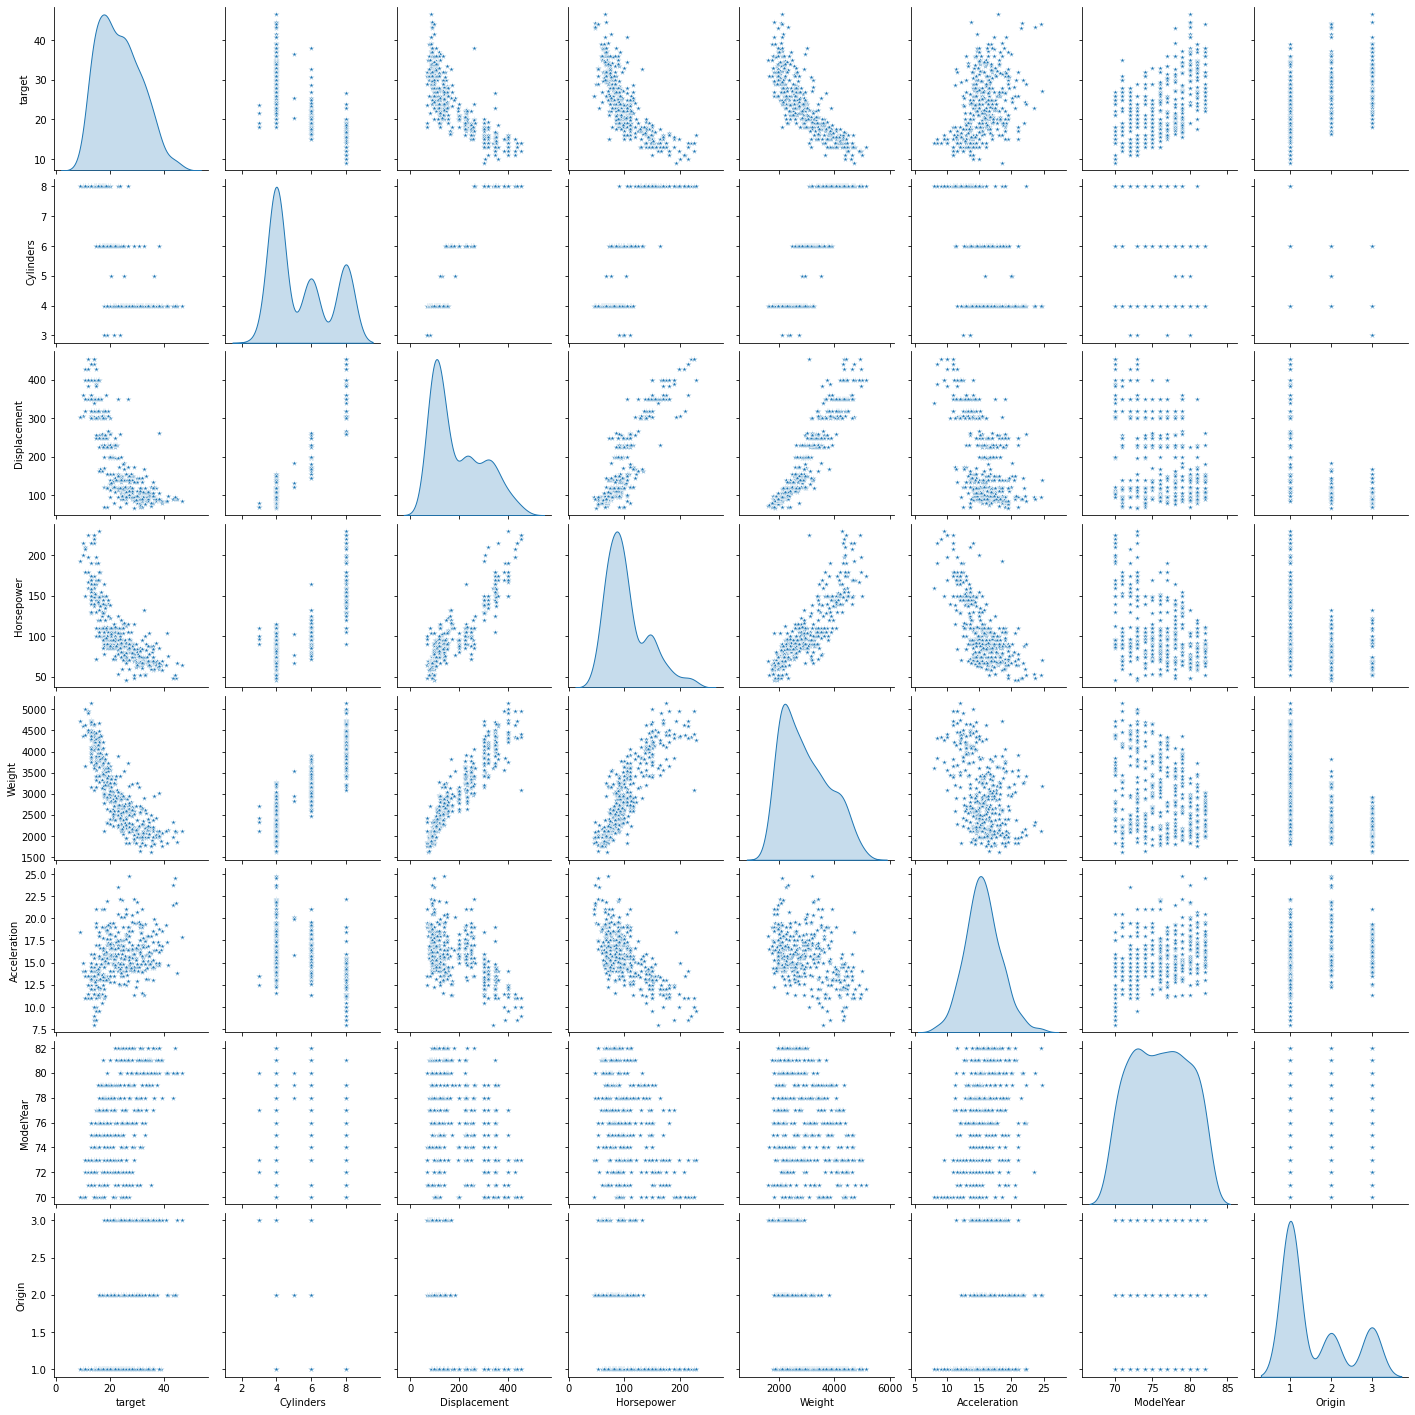

In [17]:
sns.pairplot(df, diag_kind="kde", markers="*")
plt.show()

According to previous pairplot, we could have some inferences;
    - target is right-skewed.
    - cylinders behave like a categorical variable.
    - displacement, horsepower and weight have inverse proportion with target.
    - origin is categorical variable too.
    - there are some outliers (for instance top left corner of the weigth-displacement chart.).   

Let's examine cylinders and origin (categorical variables) more. (At the feature engineering we will do more stuffs.)

<AxesSubplot:xlabel='Cylinders', ylabel='count'>

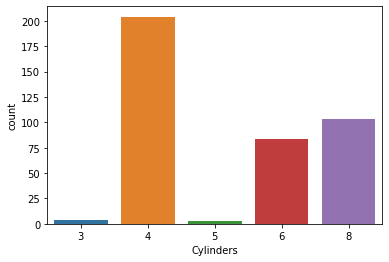

In [18]:
plt.figure()
sns.countplot(df['Cylinders'])

<AxesSubplot:xlabel='Origin', ylabel='count'>

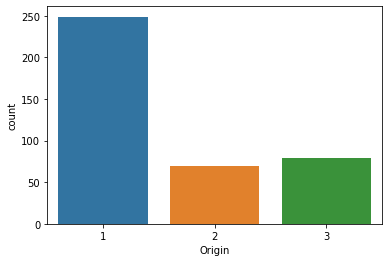

In [19]:
plt.figure()
sns.countplot(df['Origin'])

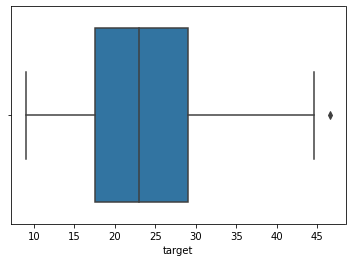

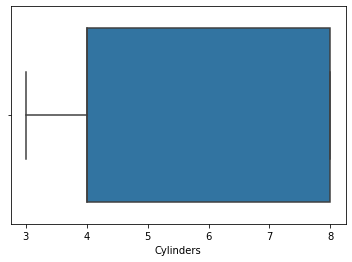

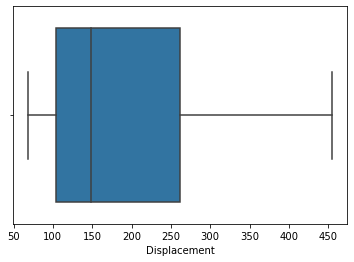

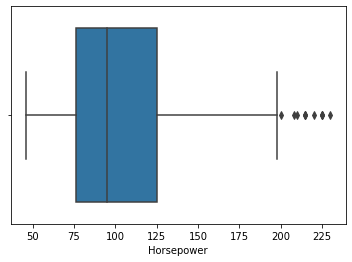

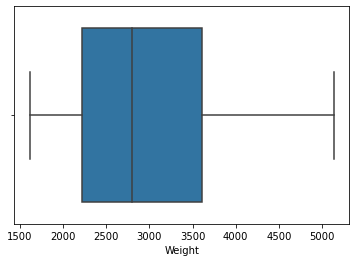

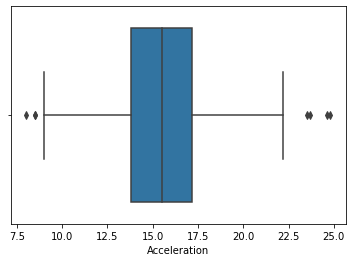

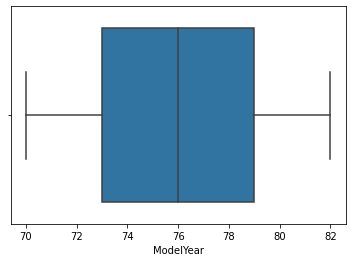

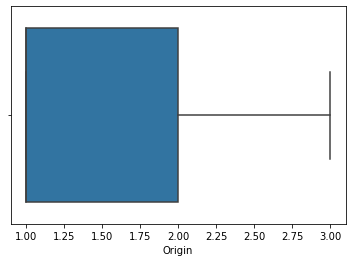

In [20]:
#boxplot

for c in df.columns:
    plt.figure()
    sns.boxplot(x = c, data = df, orient = "v")

According to boxplots, horsepower and acceleration have outliers. in the further steps, we will handle.

Now, let's do outlier detection.

In [21]:
thr = 2

horsepower_desc = df["Horsepower"].describe()
q3_hp = horsepower_desc[6]
q1_hp = horsepower_desc[4]
iqr_hp = q3_hp - q1_hp

top_limit_hp = q3_hp + thr*iqr_hp
bottom_limit_hp = q1_hp - thr*iqr_hp

filter_hp_bottom = bottom_limit_hp < df["Horsepower"]
filter_hp_top = top_limit_hp > df["Horsepower"]

filter_hp = filter_hp_bottom & filter_hp_top

df = df[filter_hp]

In [23]:
filter_hp

0      True
1      True
2      True
3      True
4      True
       ... 
393    True
394    True
395    True
396    True
397    True
Name: Horsepower, Length: 398, dtype: bool

In [22]:
thr = 2

acceleration_desc = df["Acceleration"].describe()
q3_acc = acceleration_desc[6]
q1_acc = acceleration_desc[4]
iqr_acc = q3_acc - q1_acc

top_limit_acc = q3_acc + thr*iqr_acc
bottom_limit_acc = q1_acc - thr*iqr_acc

filter_acc_bottom = bottom_limit_acc < df["Acceleration"]
filter_acc_top = top_limit_acc > df["Acceleration"]

filter_acc = filter_acc_bottom & filter_acc_top

df = df[filter_acc]

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   target        391 non-null    float64
 1   Cylinders     391 non-null    int64  
 2   Displacement  391 non-null    float64
 3   Horsepower    391 non-null    float64
 4   Weight        391 non-null    float64
 5   Acceleration  391 non-null    float64
 6   ModelYear     391 non-null    int64  
 7   Origin        391 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 27.5 KB


**Feature Engineering**

<AxesSubplot:xlabel='target', ylabel='Density'>

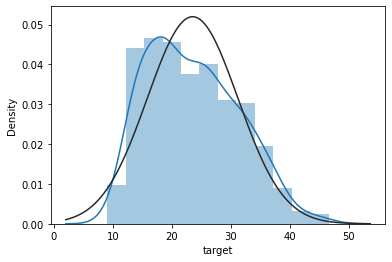

In [24]:
sns.distplot(df.target, fit = norm)

In [25]:
(mu, sigma) = norm.fit(df.target)
print('mu is {} and sigma is {}'.format(mu, sigma))

mu is 23.499232736572893 and sigma is 7.678599778082707


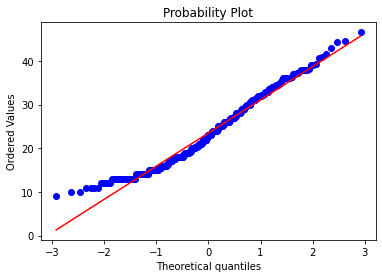

In [26]:
#qq plot
plt.figure()
stats.probplot(df.target, plot = plt)
plt.show()

<AxesSubplot:xlabel='target', ylabel='Density'>

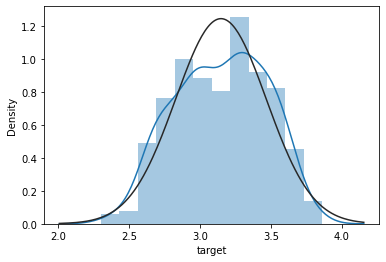

In [27]:
df.target = np.log1p(df.target)
plt.figure()
sns.distplot(df.target, fit = norm)

In [28]:
(mu, sigma) = norm.fit(df.target)
print('mu is {} and sigma is {}'.format(mu, sigma))

mu is 3.148549778053243 and sigma is 0.31986792768696354


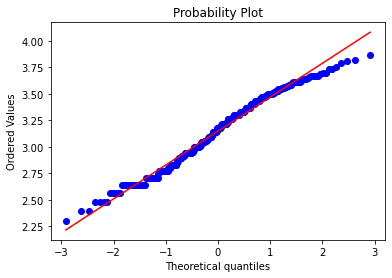

In [29]:
plt.figure()
stats.probplot(df.target, plot = plt)
plt.show()

In [30]:
skewed_feats = df.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame(skewed_feats, columns = ["skewed"])
skewness

,skewed
Horsepower,1.002620
Origin,0.915147
Displacement,0.692506
Cylinders,0.539419
Weight,0.530167
Acceleration,0.144566
ModelYear,0.010762
target,-0.134213


Results seems ok. Now target is so close to 0 which was our expectation. The other features are also close to 0 except horsepower. But it can be ignored.

In [31]:
df["Cylinders"] = df["Cylinders"].astype(str)
df["Origin"] = df["Origin"].astype(str)


df


,target,Displacement,Horsepower,Weight,Acceleration,ModelYear,Cylinders_3,Cylinders_4,Cylinders_5,Cylinders_6,Cylinders_8,Origin_1,Origin_2,Origin_3
0,2.944439,307.0,130.0,3504.0,12.0,70,0,0,0,0,1,1,0,0
1,2.772589,350.0,165.0,3693.0,11.5,70,0,0,0,0,1,1,0,0
2,2.944439,318.0,150.0,3436.0,11.0,70,0,0,0,0,1,1,0,0
3,2.833213,304.0,150.0,3433.0,12.0,70,0,0,0,0,1,1,0,0
4,2.890372,302.0,140.0,3449.0,10.5,70,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,3.332205,151.0,90.0,2950.0,17.3,82,0,1,0,0,0,1,0,0
393,3.332205,140.0,86.0,2790.0,15.6,82,0,1,0,0,0,1,0,0
395,3.496508,135.0,84.0,2295.0,11.6,82,0,1,0,0,0,1,0,0
396,3.367296,120.0,79.0,2625.0,18.6,82,0,1,0,0,0,1,0,0


In [32]:
# split to x(features) and y(target)
x = 0
x = df.drop(columns="target")
y = df.target

In [33]:
# split to train & test

test_size=0.9
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)
print(len(x_train), len(x_test))

39 352


In [34]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train) # fit and transform
x_test = scaler.transform(x_test) # just transform, already fitted

In [35]:
lr = LinearRegression()
lr.fit(x_train, y_train)
print("LR coefs: ", lr.coef_)
y_predicted_dummy = lr.predict(x_test)
mse = mean_squared_error(y_test, y_predicted_dummy)
print("Linear Regression MSE: ", mse)

LR coefs:  [-1.21101235e-01 -4.55580352e-02 -5.95395327e-02 -4.81552952e-02
  9.41933520e-02 -6.59194921e-17  5.14634974e-03 -2.47009505e-02
  2.37914694e-03  6.74877226e-03 -1.46285820e-02  2.22111701e-02
 -8.83751495e-03]
Linear Regression MSE:  0.017803776531038405


Ridge Coefs:  [-0.10285747 -0.04596053 -0.06532809 -0.04703368  0.09401689  0.
  0.01082148 -0.02307721 -0.00116098  0.00097552 -0.01534303  0.02275077
 -0.0084845 ]
Ridge Best Estimator:  Ridge(alpha=0.31622776601683794, max_iter=10000, random_state=42)
Ridge MSE:  0.01705176737178958


Text(0.5, 1.0, 'Ridge')

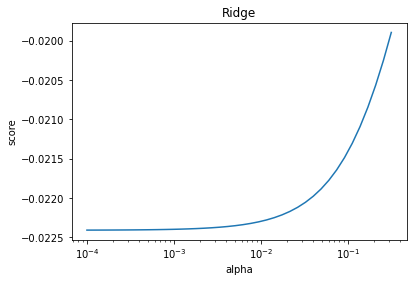

In [36]:
# let's jump up to regularization section, firstly we will use Ridge Regression

ridge = Ridge(random_state=42, max_iter=10000)

alphas = np.logspace(-4, -0.5, 40)
tuned_params = [{'alpha':alphas}]

n_folds = 5

clf = GridSearchCV(ridge, tuned_params, cv=n_folds, scoring="neg_mean_squared_error", refit=True)
clf.fit(x_train, y_train)
scores = clf.cv_results_["mean_test_score"]
score_std = clf.cv_results_["std_test_score"]

print("Ridge Coefs: ", clf.best_estimator_.coef_)
ridge=clf.best_estimator_

print("Ridge Best Estimator: ", ridge)
y_predicted_dummy = clf.predict(x_test)
mse = mean_squared_error(y_test, y_predicted_dummy)

print("Ridge MSE: ", mse)

plt.figure()
plt.semilogx(alphas, scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Ridge")

Lasso Coefs:  [-0.12039871 -0.         -0.08241224 -0.01451677  0.07258976  0.
  0.00313466 -0.         -0.         -0.         -0.          0.
  0.        ]
Lasso Best Estimator:  Ridge(alpha=0.31622776601683794, max_iter=10000, random_state=42)
Lasso MSE:  0.01648692437489997


Text(0.5, 1.0, 'Lasso')

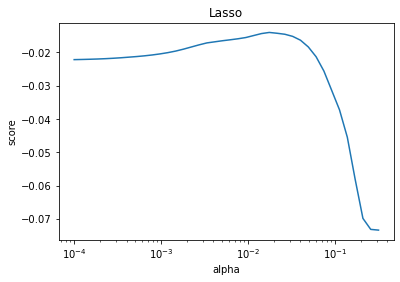

In [37]:
#the other regularization method is Lasso

lasso = Lasso(random_state=42, max_iter=10000)

alphas = np.logspace(-4, -0.5, 40)
tuned_params = [{'alpha':alphas}]

n_folds = 5

clf = GridSearchCV(lasso, tuned_params, cv=n_folds, scoring="neg_mean_squared_error", refit=True)
clf.fit(x_train, y_train)
scores = clf.cv_results_["mean_test_score"]
score_std = clf.cv_results_["std_test_score"]

print("Lasso Coefs: ", clf.best_estimator_.coef_)
lasso=clf.best_estimator_

print("Lasso Best Estimator: ", ridge)
y_predicted_dummy = clf.predict(x_test)
mse = mean_squared_error(y_test, y_predicted_dummy)

print("Lasso MSE: ", mse)

plt.figure()
plt.semilogx(alphas, scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Lasso")

eNet Coefs:  [-0.10643    -0.         -0.08756973 -0.01351859  0.07500121  0.
  0.01074348 -0.         -0.         -0.         -0.          0.0032438
  0.        ]
eNet Best Estimator:  ElasticNet(alpha=0.03257020655659783, max_iter=10000, random_state=42)
eNet MSE:  0.015808027989388126


Text(0.5, 1.0, 'eNet')

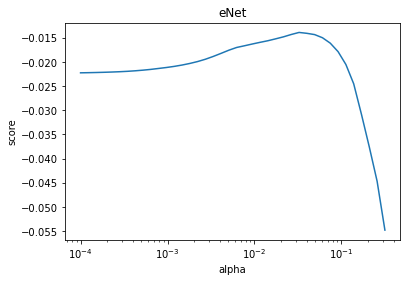

In [38]:
# the last regularization method is ElasticNet which is a combination of both Lasso and Ridge.

parametersGrid = {'alpha':alphas}
eNet = ElasticNet(random_state=42, max_iter=10000)


clf = GridSearchCV(eNet, parametersGrid, cv=n_folds, scoring="neg_mean_squared_error", refit=True)
clf.fit(x_train, y_train)
scores = clf.cv_results_["mean_test_score"]
score_std = clf.cv_results_["std_test_score"]

print("eNet Coefs: ", clf.best_estimator_.coef_)
eNet=clf.best_estimator_

print("eNet Best Estimator: ", eNet)
y_predicted_dummy = clf.predict(x_test)
mse = mean_squared_error(y_test, y_predicted_dummy)

print("eNet MSE: ", mse)

plt.figure()
plt.semilogx(alphas, scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("eNet")

In [39]:
 parametersGrid = {'nthread':[4],
                   'objective':['reg:linear'],
                   'learning_rate':[.03,.05,.07],
                   'max_depth':[4,5,6,7],
                   'min_child_weight':[4],
                   'silent':[1],
                   'subsample':[0.7],
                   'colsample_bytree':[0.7],
                   'n_estimators':[500,750,1000]}
    
model_xgb = xgb.XGBRegressor()

clf = GridSearchCV(model_xgb, parametersGrid, cv=n_folds, scoring="neg_mean_squared_error", refit=True, n_jobs=5)
clf.fit(x_train, y_train)
model_xgb = clf.best_estimator_


y_predicted_dummy = model_xgb.predict(x_test)
mse = mean_squared_error(y_test, y_predicted_dummy)

print("XGB MSE: ", mse)

[17:19:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[17:19:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:19:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[17:19:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Param

[17:20:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[17:20:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


XGB MSE:  0.018290369264929694
[17:19:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost 

[17:19:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[17:19:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:19:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[17:19:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Param

In [41]:
class AveragingModels():
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        for model in self.models_:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)
        
averaged_models = AveragingModels(models = (model_xgb, lasso))
averaged_models.fit(x_train, y_train)

y_predicted_dummy = averaged_models.predict(x_test)
mse = mean_squared_error(y_test, y_predicted_dummy)

print("Averaged Models MSE: ", mse)

[17:28:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[17:28:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Averaged Models MSE:  0.015656288343231826
